<a href="https://colab.research.google.com/github/liangli217/PyTorch_ML/blob/main/Transformer_from_scratch_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It's finally time to code up the `TransformerBlock` class. This is the msot important class to write in defining the GPT model.

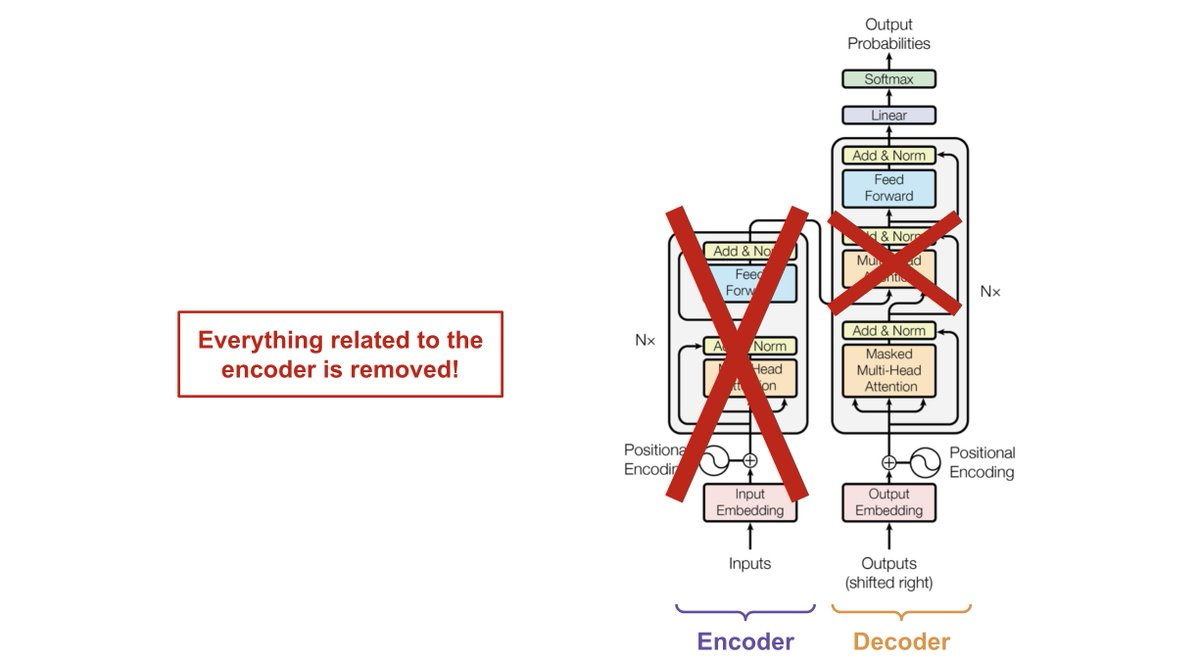

Layer Normalization vs Batch Normalization:
Batch: normalizes across the batch dimension
Layer: normalizes across the feature dimension

In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
from torchtyping import TensorType

# Even though the original diagram created by Google
# has "Norm" after Attention in the bottom component, and
# "Norm" after FeedForward in the top component, Norm should
# be applied first in both cases (before Attention & before FeedForward),
# and in each case, the output (specifically the output of attention
# in the first case & output of FeedForward in the second case) should
# be added to the tensor passed in to Norm. Researchers have found this
# architecture to be superior for LLM performance.
class TransformerBlock(nn.Module):

    def __init__(self, model_dim: int, num_heads: int):
        super().__init__()
        torch.manual_seed(0)
        self.mhsa = self.MultiHeadedSelfAttention(model_dim, num_heads)

        self.ln1 = nn.LayerNorm(model_dim)
        self.ln2 = nn.LayerNorm(model_dim)
        self.ff = self.VanillaNeuralNetwork(model_dim)

    def forward(self, embedded: TensorType[float]) -> TensorType[float]:
        # Round answer to 4 decimal places
        torch.manual_seed(0)
        normalized = self.ln1(embedded)
        first_output = embedded + self.mhsa(normalized)

        second_output = self.ff(self.ln2(first_output)) + first_output

        return torch.round(second_output, decimals = 4)




    class MultiHeadedSelfAttention(nn.Module):

        class SingleHeadAttention(nn.Module):
            def __init__(self, model_dim: int, head_size: int):
                super().__init__()
                torch.manual_seed(0)
                self.key_gen = nn.Linear(model_dim, head_size, bias=False)
                self.query_gen = nn.Linear(model_dim, head_size, bias=False)
                self.value_gen = nn.Linear(model_dim, head_size, bias=False)

            def forward(self, embedded: TensorType[float]) -> TensorType[float]:
                k = self.key_gen(embedded)
                q = self.query_gen(embedded)
                v = self.value_gen(embedded)

                scores = q @ torch.transpose(k, 1, 2) # @ is the same as torch.matmul()
                context_length, attention_dim = k.shape[1], k.shape[2]
                scores = scores / (attention_dim ** 0.5)

                lower_triangular = torch.tril(torch.ones(context_length, context_length))
                mask = lower_triangular == 0
                scores = scores.masked_fill(mask, float('-inf'))
                scores = nn.functional.softmax(scores, dim = 2)

                return scores @ v

        def __init__(self, model_dim: int, num_heads: int):
            super().__init__()
            torch.manual_seed(0)
            self.att_heads = nn.ModuleList()
            for i in range(num_heads):
                self.att_heads.append(self.SingleHeadAttention(model_dim, model_dim // num_heads))

        def forward(self, embedded: TensorType[float]) -> TensorType[float]:
            head_outputs = []
            for head in self.att_heads:
                head_outputs.append(head(embedded))
            concatenated = torch.cat(head_outputs, dim = 2)
            return concatenated

    class VanillaNeuralNetwork(nn.Module):

        def __init__(self, model_dim: int):
            super().__init__()
            torch.manual_seed(0)
            self.up_projection = nn.Linear(model_dim, model_dim * 4)
            self.relu = nn.ReLU()
            self.down_projection = nn.Linear(model_dim * 4, model_dim)
            self.dropout = nn.Dropout(0.2) # using p = 0.2

        def forward(self, x: TensorType[float]) -> TensorType[float]:
            torch.manual_seed(0)
            return self.dropout(self.down_projection(self.relu(self.up_projection(x))))


In [ ]:
model_dim = 4
num_heads = 2
embedded = [
  [[-0.6775, 1.4919, 0.8760, 0.9440],
   [0.4388, 0.5290, -0.2510, -1.2941]],
  [[2.0576, 0.6107, -0.7395, -0.2010],
   [0.4728, 1.0233, -0.9400, 2.0409]]
]

In [ ]:
transformer = TransformerBlock(model_dim =4, num_heads = 2)

In [ ]:
transformer(torch.tensor(embedded))

tensor([[[-0.8632,  1.4343,  0.9038,  1.1765],
         [ 0.5806,  0.3815,  0.0747, -1.2517]],

        [[ 2.3424,  0.8594, -0.0340, -0.0184],
         [ 0.4577,  1.7212, -0.2495,  2.3688]]], grad_fn=<RoundBackward1>)